<a href="https://colab.research.google.com/github/YunDudali/TAMU-CSCE636-Deep-learning---Project_3/blob/main/Project3_YunDu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TAMU - CSCE636 Deep Learning**

**Requirement :**

This project is on language modeling for an artificial language. We want to build a model such that given a "partial text" in the artificial language, the model can predict the next word. 

As a training dataset, a list of 5,000 texts in the artificial language are here.  (After downloading it, you can use pickle.load(open(path,'rb')) to open it. It is a list of 5,000 strings in Python. For example, a string may be 'a j a d a d c g b f a i c f b e a e a h b e a d c d c d c d b d c f '.)

From the above 5,000 strings, we have obtained 5,000 "partial texts" and the corresponding "next word". Each "partial text" consists of the first k words of the corresponding string (for some random integer k), and the corresponding "next word" is the (k+1)-th word in that string. For example, for the string 'a j a d a d c g b f a i c f b e a e a h b e a d c d c d c d b d c f ', the "partial text" may be ['a', 'j', 'a', 'd', 'a', 'd', 'c', 'g', 'b', 'f', 'a', 'i', 'c', 'f', 'b', 'e', 'a'], which is a list of the first k=17 words in the string, and the "next word" is 'e', which is the 18-th word in the string. 

Your task is to design and train a good model, which takes "partial texts" as input, and predicts the "next word" for each "partial text".


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pickle
import numpy as np
from tensorflow import keras

In [ ]:
train_input = '/content/drive/MyDrive/Colab_Notebooks/CSCE636/project3/DS_5_train_input_prefixList'
train_output = '/content/drive/MyDrive/Colab_Notebooks/CSCE636/project3/DS_5_train_input_nextWord'
original_data = '/content/drive/MyDrive/Colab_Notebooks/CSCE636/project3/DS_5_train_input'
input_language = pickle.load(open(train_input, 'rb'))
output_language = pickle.load(open(train_output, 'rb'))
original = pickle.load(open(original_data, 'rb'))

In [ ]:
new_input_language = []
for i in range(len(input_language)):
    string = ' '.join([str(item) for item in input_language[i]])
    new_input_language.append(string)

# then pair them using zip, put them in a list and shuffle it
pairs = list(zip(new_input_language, output_language))
random.shuffle(pairs)
new_input_language, output_language = zip(*pairs)
# make input and output data to be two lists
new_input_language = list(new_input_language)
output_language = list(output_language)

# split them into the training ,validation dataset
num_val_input_samples = int(0.2 * len(new_input_language))
num_val_output_samples = int(0.2 * len(output_language))

num_train_input_samples = len(new_input_language) - num_val_input_samples
num_train_output_samples = len(output_language) - num_val_output_samples

train_input_samples = new_input_language[:num_train_input_samples]
train_output_samples = output_language[:num_train_output_samples]
val_input_samples = new_input_language[num_train_input_samples:]
val_output_samples = output_language[num_train_output_samples:]

# now vectorizing the input_language and output_language
vocab_size = 100
sequence_length = 128

input_language_vectorization = layers.TextVectorization(max_tokens=vocab_size, output_mode='int',
                                                output_sequence_length=sequence_length)
output_language_vectorization = layers.TextVectorization(max_tokens=vocab_size, output_mode='int',
                                                output_sequence_length=1)
input_language_vectorization.adapt(original)
output_language_vectorization.adapt(original)


# preparing datasets for the translation task
def format_dataset(inlan, outlan):
    inlan = input_language_vectorization(inlan)
    outlan = output_language_vectorization(outlan)
    return inlan, outlan

train_ds = tf.data.Dataset.from_tensor_slices((train_input_samples, train_output_samples))
train_ds = train_ds.batch(32)
train_ds = train_ds.map(format_dataset, num_parallel_calls=4)
train_ds = train_ds.shuffle(2048).prefetch(16).cache()

val_ds = tf.data.Dataset.from_tensor_slices((val_input_samples, val_output_samples))
val_ds = val_ds.batch(32)
val_ds = val_ds.map(format_dataset, num_parallel_calls=4)
val_ds = val_ds.shuffle(2048).prefetch(16).cache()

# def an Embedding layer
embed_dim = 128
num_heads = 4
dense_dim = 1024

def self_Embedding(inputs):
    length = tf.shape(inputs)[-1]
    positions = tf.range(start=0, limit=length, delta=1)
    embedded_tokens = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)(inputs)
    embedded_positions = layers.Embedding(input_dim=sequence_length, output_dim=embed_dim)(positions)
    embedded_out = embedded_positions + embedded_tokens
    return embedded_out, tf.math.not_equal(inputs, 0)


language_keras_input = keras.Input(shape=(sequence_length,), dtype="int64", name="input_language")
embedded_source, source_mask = self_Embedding(language_keras_input)
encoder_out = embedded_source

# the 1st Encoder Block
transformer_encoder = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim,
                            dropout=0.2)(encoder_out, encoder_out, attention_mask=source_mask[:, tf.newaxis, :])
res = layers.LayerNormalization()(transformer_encoder + encoder_out)
res = layers.Dropout(0.2)(res)
transformer_encoder = layers.Dense(dense_dim, activation="relu")(res)
transformer_encoder = layers.Dropout(0.2)(transformer_encoder)
transformer_encoder = layers.Dense(embed_dim)(transformer_encoder)
encoder_out = layers.LayerNormalization()(transformer_encoder + res)

# the 2nd Encoder Block
transformer_encoder = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim,
                            dropout=0.2)(encoder_out, encoder_out, attention_mask=source_mask[:, tf.newaxis, :])
res = layers.LayerNormalization()(transformer_encoder + encoder_out)
res = layers.Dropout(0.2)(res)
transformer_encoder = layers.Dense(dense_dim, activation="relu")(res)
transformer_encoder = layers.Dropout(0.2)(transformer_encoder)
transformer_encoder = layers.Dense(embed_dim)(transformer_encoder)
encoder_out = layers.LayerNormalization()(transformer_encoder + res)


encoder_out = encoder_out[:, 0, :]
encoder_out = layers.Dense(vocab_size, activation="softmax")(encoder_out)

model = keras.Model(language_keras_input, encoder_out)
model.summary()

keras.backend.clear_session()

model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="/content/drive/MyDrive/Colab_Notebooks/CSCE636/project3/chongpao2_1000_project3_yun.keras",
        save_best_only=True,
        monitor="val_loss")
]


history = model.fit(train_ds, epochs=1000, callbacks=callbacks, validation_data=val_ds, shuffle=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_language (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 tf.compat.v1.shape (TFOpLambda  (2,)                0           ['input_language[0][0]']         
 )                                                                                                
                                                                                                  
 tf.__operators__.getitem (Slic  ()                  0           ['tf.compat.v1.shape[0][0]']     
 ingOpLambda)                                                                                     
                                                                                              

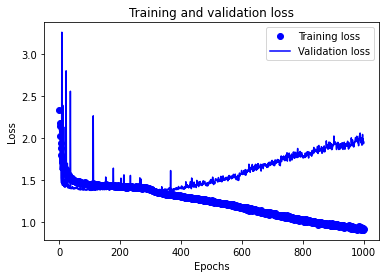

In [ ]:
history_dict = history.history
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

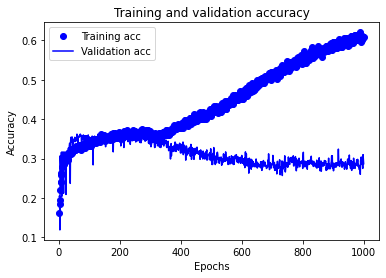

In [ ]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()